# Семинар 5. Методы классификации

## Линейный дискриминационный анализ (LDA), Квадратичный дискриминационный анализ (QDA), метод k ближайших соседей (kNN)

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))


## Настройка окружения и предобработка данных
(см. Семинар 3)

In [ ]:
# Установка библиотек и глобальных параметров
!pip -q install --upgrade statsmodels

from IPython.core.interactiveshell import InteractiveShell   
InteractiveShell.ast_node_interactivity = "all"

import numpy as np, pandas as pd, matplotlib.pylab as plt, seaborn as sns, statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

pd.set_option('max_rows', 15, 'max_columns', 500, 'max_colwidth', 1, 'precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
plt.rcParams['figure.figsize'] = [16, 6]

     |████████████████████████████████| 9.5MB 3.9MB/s 


In [ ]:
csv_url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv'
df = pd.read_csv(csv_url)
df.columns=['psgr','srv','pcls','name','sex','age','sibsp','parch','tkt','fare','cab','emb']
df.sex = 1*(df.sex=='male')

In [ ]:
df_filtered = df.drop(['cab', 'tkt', 'name'], axis=1)

df_filtered["emb_is_S"] = (df_filtered["emb"] == "S").astype(int)
df_filtered["emb_is_C"] = (df_filtered["emb"] == "C").astype(int)

df_filtered = df_filtered.drop(["emb"], axis=1)

median_age = df_filtered["age"].median()
print("Filling NA values with age", median_age)
df_filtered = df_filtered.fillna(median_age)

fare_max = df_filtered['fare'].quantile(0.95)
df_filtered.loc[df_filtered['fare'] > fare_max, "fare"] = fare_max

sibsp_max = df_filtered['sibsp'].quantile(0.95)
df_filtered.loc[df_filtered['sibsp'] > sibsp_max, "sibsp"] = sibsp_max

Filling NA values with age 28.0


In [ ]:
df_filtered.head()

,psgr,srv,pcls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
0,1,0,3,1,22.0,1.0,0,7.25,1,0
1,2,1,1,0,38.0,1.0,0,71.28,0,1
2,3,1,3,0,26.0,0.0,0,7.92,1,0
3,4,1,1,0,35.0,1.0,0,53.10,1,0
4,5,0,3,1,35.0,0.0,0,8.05,1,0


# Линейный дискриминационный анализ (LDA)

## Сравнение с логистической регрессией

Логистическая регрессия не работает хорошо, когда:
* классы хорошо разделены
* * *n* мал и распределение предикторов *X* приблизительно нормально в каждом из классов
* имеется > 2 целевых классов (необходимо расширение на несколько классов)

## Using Bayes' Theorem for Classification

*Теорема Байеса*:
$$Pr(Y = k|X = x) = \frac{Pr(Y = k) Pr(X = x | Y = k) }{\sum_{l=1}^K Pr(Y = l) Pr(X = x | Y = l) }$$

Или, если примем $\pi_k = Pr(Y = k)$, $f_k(x) = Pr(X = x | Y = k)$:

$$Pr(Y = k|X = x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K \pi_l f_l(x)}$$


$p_k(x) = Pr(Y = k|X = x)$ - *апостериорная* вероятность того, что наблюдение $X = x$ принадлежит *k*му классу.


LDA позволяет нам вычислить апостериорную вероятность того, что наблюдаемая выборка, $x$, принадлежит к некоторому классу $y = 0, 1$, т.е. $p_y(x) := \mathbb{P}[Y=y|X=x]$. Применяя теорему Байеса, получаем: $$p_y(x) = \frac{\pi_y f_y(x)}{\pi_0 f_0(x) + \pi_1 f_1(x)}$$ где $f_y = \mathbb{P}[X=x|Y=y]$ - плотность случайного вектора $X = (X_{sex},...,X_{parch})$. Чтобы вычислить $p_y$, нам нужно оценить следующие распределения в правой части:
1.   Априорные вероятности $\pi_0 = Pr(Y = 0),\pi_1 = Pr(Y = 1)$ как доли погибших и выживших.
2.   LDA предполагает: $f_y(x)\sim$ многомерной нормальной плотности с идентичной ковариационной матрицей для каждого класса, $\sum_{y=0} = \sum_{y=1} \in \mathbb{R}^{6\times 6}$.

В действительности мы получаем $X_{\mathrm{sex}, y} \sim \mathrm{Bern}(p_y), X_{\mathrm{age}, y} \sim N(\mu_y, \sigma_y^2), X_{\mathrm{parch},y} \sim \mathrm{Poisson}(\lambda_y)$, и т.д.

О случае негауссовых распределений см. [эту дискуссию](https://stats.stackexchange.com/a/110954/114581). Объяснение в [ESL](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf) 4.3:
> Since this derivation of the LDA direction via least squares does not use a
Gaussian assumption for the features, its applicability extends beyond the
realm of Gaussian data. However the derivation of the particular intercept
or cut-point given in (4.11) does require Gaussian data. Thus it makes
sense to instead choose the cut-point that empirically minimizes training
error for a given dataset.

Итак, рассматривая наблюдение $x$ (во всех признаках), мы вычисляем $p_0(x),p_1(x)$ и относим $x$ к классу с наибольшей апостериорной вероятностью. Вот и все. Вы можете видеть, что это легко применимо для любого числа классов, в то время как логистическая регрессия так не может.


## Задание 5.1

1.  Оцените априорные вероятности $\pi_0, \pi_1$.
2.  Оцените $X_{\mathrm{sex},y=1} \sim \mathrm{Bern}(p)$, если $p$ - вероятность обнаружить женщин среди выживших.
3.  Оцените среднее и дисперсию для `age` среди погибших и выживших пассажиров.


# Подготовка данных для LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = tts(
    df_filtered.drop(["srv"], axis=1), df_filtered["srv"], test_size=0.3,
    random_state=0
)

print("Train: input shape is ", X_train.shape, "output shape is ", y_train.shape)
print("Test: input shape is ", X_test.shape, "output shape is ", y_test.shape)
print("Unique values of targets (should be 0 or 1):", np.unique(y_train))

Train: input shape is  (623, 9) output shape is  (623,)
Test: input shape is  (268, 9) output shape is  (268,)
Unique values of targets (should be 0 or 1): [0 1]


In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

def acc_score(model):
    return np.mean(cross_val_score(model, X_train, y_train, cv=k_fold, scoring="accuracy"))

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print("\nAccuracy: " + str(acc_score(lda)))

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


Accuracy: 0.7881548387096775


In [ ]:
probas_test = lda.predict_proba(X_test)

In [ ]:
probas_test[:10]

array([[0.9008, 0.0992],
       [0.9377, 0.0623],
       [0.9341, 0.0659],
       [0.0304, 0.9696],
       [0.2525, 0.7475],
       [0.5643, 0.4357],
       [0.0536, 0.9464],
       [0.0462, 0.9538],
       [0.5006, 0.4994],
       [0.2067, 0.7933]])

In [ ]:
y_pred = lda.predict(X_test)

In [ ]:
y_pred = lda.predict(X_test)
accuracy_score(y_test, y_pred)

0.7947761194029851

# Квадратичный дискриминационный анализ (QDA)
Уравнение для QDA:
$$ \Large \delta_k (x)= \rm -{1 \over 2} (x - \mu_x)^T \rm {\sum_k^{-1}} (x- \mu_k) \rm -{1 \over 2} \rm {\log |{\sum_k}}| + \log{\pi_k}$$.

QDA предполагает многомерную нормаль для вектора признаков каждого класса, но с различными ковариационными матрицами, $\sum_{y=0} \neq \sum_{y=1}, \sum_{y} \in \mathbb{R}^{6\times 6}$.

Априорные вероятности и средние значения те же, что и в LDA, но ковариации (не показаны) вычисляются отдельно для каждого класса $y = 0, 1$.

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# print("\nAccuracy: " + str(acc_score(qda)))

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [ ]:
y_pred = qda.predict(X_test)
accuracy_score(y_test, y_pred)

0.7985074626865671

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


Accuracy: 0.7947761194029851


# k ближайших соседей (kNN)

kNN - это непараметрический метод оценки. Он не делает никаких предположений о распределении границы принятия решения. В случае, когда искомая граница принятия решения нелинейна, kNN должен превосходить логистическую регрессию и LDA.

Два основных недостатка kNN:
* kNN не выcчитывает важность признаков (нет таблицы коэффициентов)
* Нужно прогнать для каждого $k=1,2,...,K$, количества соседей, чтобы определить "лучший" $k$.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print("Accuracy: " + str(acc_score(knn)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

Accuracy: 0.6356774193548387


In [ ]:
print("Accuracy:{}".format(accuracy_score(y_test,pred)))

Accuracy:0.7126865671641791


Оптимизируем модель, найдя оптимальное значение $K$.

In [ ]:
# Список нечётных k для kNN
neighbors = list(range(1,40,2))

cv_scores = [ ]

# 10-фолдовая кросс-валидация
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "accuracy")

    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    
    cv_scores.append(accuracy_score(y_test,pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=23, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=33, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=39, p=2,
                     weights='uniform')

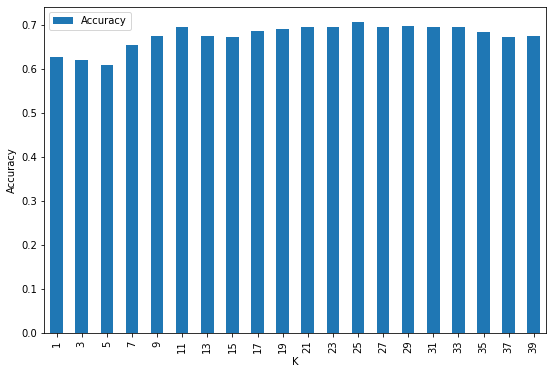

In [ ]:
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in neighbors], "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize=(9,6))
    plt.ylabel('Accuracy')
    plt.show()

plot_accuracy(cv_scores)

# del cv_scores

# Сравнение методов классификации

Давайте напишем несколько функций, чтобы облегчить вычисление соответствующих оценок и построение графиков.

In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_model(model_used):
    cm = confusion_matrix(y_test, model_used.predict(X_test))
    col = ["Predicted Dead", "Predicted Survived"]
    cm = pd.DataFrame(cm)
    cm.columns = ["Predicted Dead", "Predicted Survived"]
    cm.index = ["Actual Dead","Actual Survived"]
    cm[col] = np.around(cm[col].div(cm[col].sum(axis=1), axis=0), decimals=2)
    return cm

In [ ]:
from sklearn import metrics

def aucscore(model, has_proba=True):
    if has_proba:
        fpr, tpr, thresh = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        # fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
    else:
        fpr, tpr, thresh = metrics.roc_curve(y_test, model.decision_function(X_test))
    x = fpr
    y = tpr
    auc = metrics.auc(x, y)
    return auc

def plt_roc_curve(name, model, has_proba=True):
    if has_proba:
        fpr, tpr, thresh = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    else:
        fpr, tpr, thresh = metrics.roc_curve(y_test, model.decision_function(X_test))
    x = fpr
    y = tpr
    auc = metrics.auc(x, y)
    plt.figure(figsize=(8,8))
    plt.plot(x, y, label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

Прогоним данные через наши модели ещё раз:

In [ ]:
# LDA
lda.fit(X_train, y_train)

# QDA
qda.fit(X_train, y_train)

# kNN
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C=1e-5, max_iter=2, solver='liblinear')
log.fit(X_train, y_train)

log2 = LogisticRegression(max_iter=1000)
log2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

,Predicted Dead,Predicted Survived
Actual Dead,0.84,0.16
Actual Survived,0.28,0.72


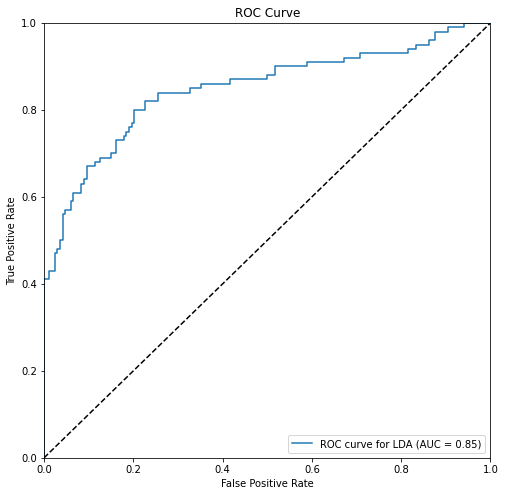

In [ ]:
confusion_matrix_model(lda)
plt_roc_curve("LDA", lda, has_proba=True)

,Predicted Dead,Predicted Survived
Actual Dead,0.83,0.17
Actual Survived,0.26,0.74


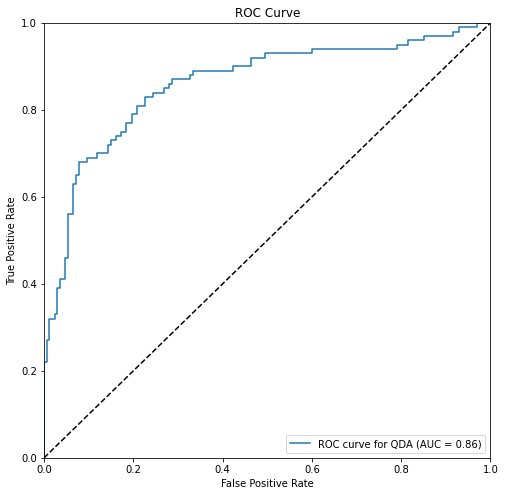

In [ ]:
confusion_matrix_model(qda)
plt_roc_curve("QDA", qda, has_proba=True)

,Predicted Dead,Predicted Survived
Actual Dead,0.89,0.11
Actual Survived,0.64,0.36


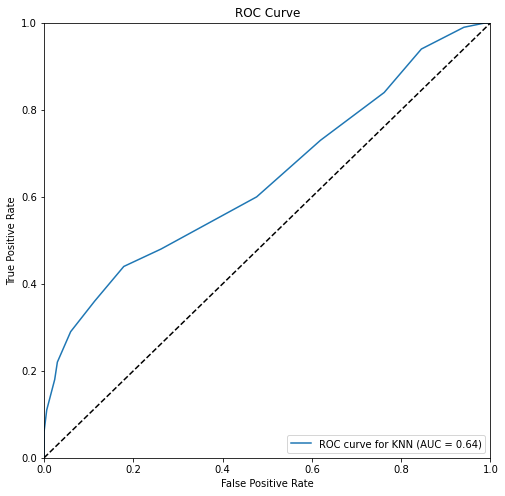

In [ ]:
confusion_matrix_model(knn)
plt_roc_curve("KNN", knn, has_proba=True)

## Упражнение 5.2

Отобразите ROC-кривые для LDA, QDA и kNN на одном графике.

## Упражнение 5.3 (бонусные баллы)

Придумайте модель классификации, которая будет иметь ROC AUC не менее 0.87.